# Optimised Python

## Vectorizing Operations

In this section we will look at a few useful built in methods for making our Python code more efficient. In the following example, we will look specifically at **vectorizing operations**.

**Vectorization**: to vectorize something means that instead of performing the computation individually on each element of a dataset, the computation can be performed simultaneously on the entire dataset.

In [5]:
import math
import numpy as np
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In this example, we will use a short function that we define below.

As the name suggests, `cart2pol` converts a pair of cartesian coordinates [x, y] to polar coordinates [r, phi].

In [6]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi)

<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Polar_to_cartesian.svg/1024px-Polar_to_cartesian.svg.png#left" style="width:300px;float: left;"/>

An example using the function:

In [7]:
x = 3
y = 4
r, phi = cart2pol(x,y)

print('r   = ',r,'\nphi = ' ,phi)

r   =  5.0 
phi =  0.9272952180016122


Now, what if we want to convert a Python `list` of multiple cartesian coordinates to polar coordinates?
* We might think to use a `loop` that loops through both lists and performs the conversion for each x-y pair, one at a time:

In [25]:
def cart2pol_list(list_x, list_y):
    # Prepare empty lists for r and phi values
    r = []
    phi = []
    
    # Loop through the lists of x and y, calculating the r and phi values
    for i in range(len(list_x)):
        r.append(np.sqrt(list_x[i]**2 + list_y[i]**2))
        phi.append(np.arctan2(list_y[i], list_x[i]))
    
    return(r, phi)

Now, let's use our new function that we used to handle lists.
* First, let's create a list of arbitrary x and y values.

In [26]:
# Create a range of x and y values
x_list = [i for i in np.sin(np.arange(0,2*np.pi,0.1))]
y_list = [i for i in np.cos(np.arange(0,2*np.pi,0.1))]

Just as a quick visualization, these coordinates make a circle centered at [0,0]:

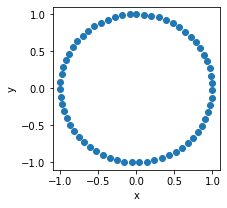

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(x_list,y_list)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Now, let's actually convert the lists of x and y values into polar coordinates using the function we wrote specifically to handle lists, `cart2pol_list`.

In [53]:
# Convert list of x and y values to polar coordinates
r_list, phi_list = cart2pol_list(x_list,y_list)

print(r_list)
print(phi_list)

The function seems to work just fine! So what's the big deal?

In reality, when you start working with large datasets, looping through each data point to do calculations can be incredibly inefficient. For example, in the last notebook, our dataset had:
* 360x396 data points in the latitude and longitude dimensions
* 5 vertical layers
* 6 time steps

Multiply all those together, and you have a total of 4,276,800 data points!

How long would it take if we used a loop to convert every single one of those points into polar coordinates? Let's try it out:

In [29]:
# Make 4,276,800 coordinate pairs to convert to polar coordinates
x_list = [i for i in np.sin(np.linspace(0,2*np.pi,4276800))]
y_list = [i for i in np.cos(np.linspace(0,2*np.pi,4276800))]

# Use our looping function to convert:
r_list, phi_list = cart2pol_list(x_list,y_list)

So surely there is a better way to make our functions work for lists of inputs? Luckily, NumPy is designed to do just that!

If we convert our lists to NumPy arrays, then NumPy can performed vectorized operations on them.

* **To vectorize something** means that instead of performing the computation individually on each element of a dataset, the computation can be performed simultaneously on the entire dataset.
* Vectorization is possible using NumPy because `numpy arrays` convert all data points within a data set into the **same data type**. This is not the case with lists.

But how do they perform?

We can use Python's magic `%timeit` function to test this:

In [38]:
%timeit cart2pol_list(x_list, y_list)

4.29 ms ± 496 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Lastly, our original `cart2pol` actually already accepts `numpy arrays` as input - i.e., `cart2pol` already performs a vectorized computation. We can see that because the `sqrt()` and `arctan2()` functions that we use in `cart2pol` are from the NumPy package.

So first, let's convert our lists into numpy arrays to prepare for vectorized operations.

In [20]:
x_nparray = np.array(x_list)
y_nparray = np.array(y_list)

Now, let's actually time this vectorized operation:

In [44]:
%timeit cart2pol(x_nparray, y_nparray)

22.4 µs ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


From our experiments with `%timeit`, we learn the following:
- Using **`numpy functions`** directly on arrays was 1-2 orders of magnitude faster looping through a list!
- Thus, when possible, it is more efficient to use **`numpy arrays`** than lists

***
***

## Multiprocessing
Another important consideration when code becomes computationally intensive is **multiprocessing**. Multiprocessing allows separate memory on your computer to run each process or program. Python normally runs on one core, so you won't feel the full benefit of your quad-core or greater machine. You can see this when you run a section of code. To demonstrate the effect of multiprocessing we'll need some more interesting maths:

In [46]:
def do_maths(start=0, num=10):
    pos = start
    big = 1000 * 1000
    ave = 0
    while pos < num:
        pos += 1
        val = math.sqrt((pos - big) * (pos - big))
        ave += val / num

    return int(ave)

In [47]:
t0 = datetime.now()

do_maths(num=30000000)

dt = datetime.now() - t0
print("Done in {:,.2f} sec.".format(dt.total_seconds()))

Done in 7.37 sec.


In [45]:
import multiprocessing

In [52]:
t0 = datetime.now()

pool = multiprocessing.Pool()
processor_count = multiprocessing.cpu_count()
# processor_count = 2 # we can Python to use a specific number of cores if desired

print(f"Computing with {processor_count} processor(s).")
tasks = []
for n in range(1, processor_count + 1):
    task = pool.apply_async(do_maths, (30000000 * (n - 1) / processor_count,
                                      30000000 * n / processor_count))
    
    tasks.append(task)

pool.close()
pool.join()

dt = datetime.now() - t0
print("Done in {:,.2f} sec.".format(dt.total_seconds()))


Note that you can recover results stored in the task list with `get()`. This list will be in the same order as that which you used to spawn the processes:

In [ ]:
for t in tasks:
    print(t.get())

The structure of a multiproccess call is:

```python
pool = multiprocessing.Pool() # Make a pool ready to recieve tasks
results = [] # empty list for results
for n in range(1, processor_count + 1): # Loop for assigning a number of tasks
    result = pool.appy_async(function, (arguments)) # make a task by passing it a function and arguments
    results.append(result) # when result(s) of this task are ready, append them to the list

pool.close() # tell async there are no more tasks coming
pool.join() # start running the tasks concurrently

for t in results:
    t.get() # retrieve your results, You could print or assign each result to a variable for later analysis
```

## Why can't we multithread in Python?

If you have experience of other programming languages, you may wonder why we can't assign tasks to multiple threads to speed up execution (multithreading means sharing the same memory by multiple processes).

We are prevented from doing this by the Global Interpreter Lock (GIL). This is a lock on the interpreter which ensures that only one thread can be in a state of execution at any one time. This is essential to protect Python's reference system that keeps track of all of the objects in memory. 

To get around this lock we spawn several processes which each have their own instance of the interpreter and allocated memory so cannot block one another or cause mischief with references. There's a great summary of the GIL on the [Real Python website](https://realpython.com/python-gil/).

In conclusion, multithreading won't speed up your compute heavy calcualtions as only one thread can execute at any time. Use multiprocessing instead.

## References

Multiprocessing example adapted from [Talk Python To Me Training: async techniques](https://training.talkpython.fm/courses/details/async-in-python-with-threading-and-multiprocessing).